<a href="https://colab.research.google.com/github/Prerna5194/COVID-19-CT-Classification/blob/master/43_Prerna_Sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the required libraries and packages**

In [0]:
import os
from os.path import join
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn .preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot,plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D,Dropout,Flatten,Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

**Part 1: Steps to generate Dataset for training and testing the model**

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

**Preparing the folder structure and mapping the images names from the respective text files to the respective train and test folders.**

> Folder Structure:

> Dataset

> -------->Train

> ---------------> CT_COVID

> ---------------> CT_NonCOVID

> -------->Test

> ---------------> CT_COVID

> ---------------> CT_NonCOVID

In [0]:
# Setting the training and test dataset path
script_dir = '/content/drive/My Drive/Dataset'
training_set_path = '/content/drive/My Drive/Dataset/train'
test_set_path = '/content/drive/My Drive/Dataset/test'
path_covid_images = '/content/drive/My Drive/Dataset/test/CT_COVID'
path_non_covid_images = '/content/drive/My Drive/Dataset/test/CT_NonCOVID'

In [0]:
# This code takes the images names from the trainCT_Covid.csv file
import csv
names1 = []
file = open(script_dir + '/trainCT_Covid.csv')
lns = csv.reader(file)
for line in lns:
    nam = line [0]
    names1.append(nam)

# This code gets the images name from the main CT_COVID folder.
all_covid_names = []
directoryPath =  path_covid_images
os.chdir(directoryPath)
folder_list=os.listdir(directoryPath)
for folders, sub_folders, file in os.walk(directoryPath):
    for name in file:
        if name.endswith(".png"):
            all_covid_names.append(name)
            
# This code moves CT_COVID train images to train -> CT_COVID folder.
import shutil
for i in names1:
    if i in names:
        shutil.move(i, script_dir + '/train/CT_COVID')            


# This code gets the images names from the testCT_Covid1.csv file. 
import csv

testnames1 = []
file = open(script_dir + '/testCT_Covid1.csv')
lns = csv.reader(file)
for line in lns:
    nam = line [0]
    testnames1.append(nam)

# This code moves CT_COVID test images to test -> CT_COVID folder.
import shutil
for i in testnames1:
    if i in all_covid_names:
        shutil.move(i, script_dir + '/test/CT_COVID') 

normal_train_names1 = []
file = open(script_dir + '/trainCT_NonCOVID.csv')
lns = csv.reader(file)
for line in lns:
    nam = line [0]
    normal_train_names1.append(nam)

# This code gets the images name from the main CT_NonCOVID folder. Don't run it again.
all_noncovid_names = []
normal_cases_path = os.path.dirname(script_dir + '/CT_NonCOVID')
#directoryPath =  path_non_covid_images
os.chdir(normal_cases_path)
folder_list=os.listdir(normal_cases_path)
for folders, sub_folders, file in os.walk(normal_cases_path):
    for name in file:
        if (name.endswith(".png") or name.endswith(".jpg")):
            all_noncovid_names.append(name)
            
# This code moves CT_NonCOVID train images to train -> CT_NONCOVID folder.
import shutil
for i in normal_train_names1:
    if i in all_noncovid_names:
        shutil.move(i, script_dir + '/train/CT_NonCOVID')

# This code gets the images names from the testCT_NonCovid.csv file. 
import csv
normal_test_names1 = []
file = open(script_dir + '/testCT_NonCOVID.csv')
lns = csv.reader(file)
for line in lns:
    nam = line [0]
    normal_test_names1.append(nam)

# This code gets the images name from the main CT_NonCOVID folder. Don't run it again.
all_noncovid_names = []
normal_cases_path = os.path.dirname(script_dir + '/CT_NonCOVID')
#directoryPath =  path_non_covid_images
os.chdir(normal_cases_path)
folder_list=os.listdir(normal_cases_path)
for folders, sub_folders, file in os.walk(normal_cases_path):
    for name in file:
        if (name.endswith(".png") or name.endswith(".jpg")):
            all_noncovid_names.append(name)
            
# This code moves CT_NonCOVID test images to test -> CT_NONCOVID folder.
import shutil
for i in normal_test_names1:
    if i in all_noncovid_names:
        shutil.move(i, script_dir + '/test/CT_NonCOVID')

**Part 2: Architecture of the Model**

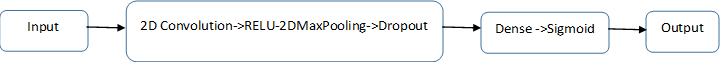

In [0]:
# Step 1 - Initialising the CNN
classifier = Sequential()
 
# Step 2 - Convolution
input_size = (150,150)
classifier.add(Conv2D(64, (3, 3),padding='same', input_shape=(*input_size, 1), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2 is optimal
classifier.add(Dropout(0.5))
# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5))

# Step 3 - Flattening
classifier.add(Flatten())
 
# Step 4 - Full connection
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(units=1, activation='sigmoid'))
 
classifier.summary()

# Compiling the CNN
classifier.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

**Part 3: Fitting the CNN Classifier to the images**

In [0]:
batch_size = 16
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
 
test_datagen = ImageDataGenerator(rescale=1. / 255)
 
training_set = train_datagen.flow_from_directory(training_set_path,
                                                 target_size=input_size,
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='binary')
 
test_set = test_datagen.flow_from_directory(test_set_path,
                                            target_size=input_size,
                                            color_mode='grayscale',
                                            batch_size=batch_size,
                                            class_mode='binary')
                                            
checkpointer = ModelCheckpoint(filepath="Covid_best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

**Part 4: Training the Model**

In [0]:
model_backup_path = '/content/drive/My Drive/Dataset/Covid_model.h5'

In [0]:
model_backup_path

In [0]:
history = classifier.fit_generator(training_set,
                         steps_per_epoch = 425/batch_size,
                         epochs = 50,
                         validation_data=test_set,
                         validation_steps = 203/batch_size)

# Save model
classifier.save(model_backup_path)
print("Model saved to", model_backup_path)

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

**Part 5: Displaying curves of loss and accuracy during training**

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

In [0]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
print("training_accuracy", history.history['accuracy'][-6])
print("validation_accuracy", history.history['val_accuracy'][-6])

print("training_loss", history.history['loss'][-6])
print("validation_loss", history.history['val_loss'][-6])

In [0]:

training_set.class_indices

In [0]:
test_set.class_indices

In [0]:
y_test = []
y_actual = []

In [0]:
from keras.preprocessing import image
for i in os.listdir("/content/drive/My Drive/Dataset/test/CT_NonCOVID/"):
    img = image.load_img("/content/drive/My Drive/Dataset/test/CT_NonCOVID/" + i, target_size = (150, 150),color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    p = classifier.predict_classes(img)
    y_test.append(p[0, 0])
    y_actual.append(1)
    
for i in os.listdir("/content/drive/My Drive/Dataset/test/CT_COVID/"):
    img = image.load_img("/content/drive/My Drive/Dataset/test/CT_COVID/" + i, target_size = (150, 150),color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    p = classifier.predict_classes(img)
    y_test.append(p[0, 0])
    y_actual.append(0)

In [0]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [0]:
cm = confusion_matrix(y_actual, y_test)

**Plotting the Confusion Matrix**

In [0]:
sns.heatmap(cm, cmap = 'plasma', annot = True)
plt.show()

**Part 6: Predicting the class of unseen images**

In [0]:
img_src = '/content/drive/My Drive/Dataset/val/CT_COVID/2020.03.13.20035212-p23-158.png'
img = image.load_img(img_src, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [0]:
img_src2 = '/content/drive/My Drive/Dataset/val/CT_NonCOVID/1071.png'
img1 = image.load_img(img_src2, target_size=(150, 150))
img_tensor1 = image.img_to_array(img1)
img_tensor1 = np.expand_dims(img_tensor1, axis=0)
img_tensor1 /= 255.
plt.imshow(img_tensor1[0])
plt.show()
print(img_tensor1.shape)

In [0]:
test_image = image.load_img(img_src, target_size = (150, 150), color_mode= 'grayscale')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'NonCovid'
else:
    prediction = 'Covid'

print('Prediction is ', prediction)

In [0]:
test_image2 = image.load_img(img_src1, target_size = (150, 150), color_mode= 'grayscale')
test_image2 = image.img_to_array(test_image2)
test_image2 = np.expand_dims(test_image2, axis = 0)
result = classifier.predict(test_image2)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'NonCovid'
else:
    prediction = 'Covid'

print('Prediction is ', prediction)